# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "./data/train.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
# import all packages here
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
%matplotlib inline

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


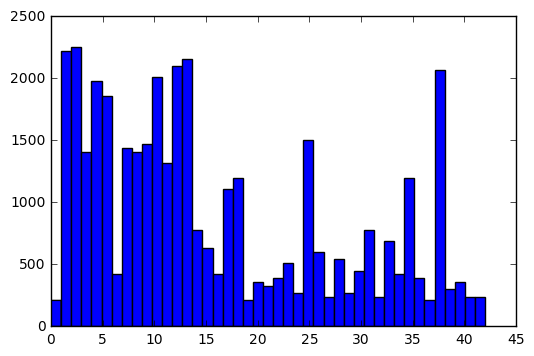

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

###First let us look at histogram of class labels in training set
plt.figure(1)
plt.hist(y_train, bins=n_classes)
plt.show()


#### <font color='green'> We can see that class distribution is not very symmetric and hence the tuned model may not behave well for certain images which have lower frequency of occurance in training set.</font>

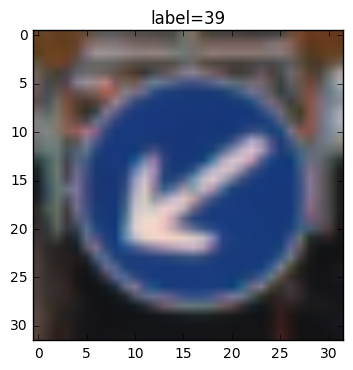

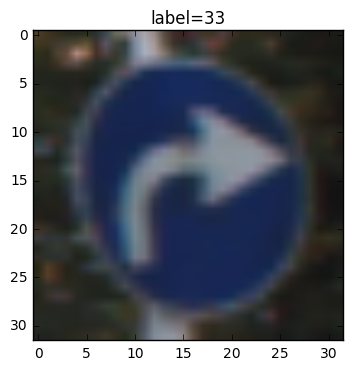

In [5]:
# We now look at some of the random images
samples = np.random.choice(n_train,2)
images = X_train[samples]
labels = y_train[samples]

for image, label in zip(images, labels):
    plt.figure()
    plt.title('label={}'.format(label))
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
# each image is 32x32x3. We normalise pixel values from 0-255 -> 0-1

# convert X dataset into float and then divide by 255 
# to convert all the pixel values from 0-255 -> 0-1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train /= 255
X_test /= 255

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The input is color image each of size 32x32x3. The value of each pixel ranges from 0-255. I normalised the data to the range 0-1 by dividing each pixel value by 255.

In [7]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
# Split training set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)



### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
Training set is broken into train and validation set. Test set is loaded form provided pickle file. Training set will be used to train a convolutional neural net. Validation set will be used to decide hyper parameter i.e. number of optimal EPOCHs that give the best model. After this point, test set will be used to report the fianl performance of the trained model on an unseen dataaset.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# parameters to be defined here
batch_size = 64
num_classes = 43
learning_rate = 1e-3
epochs =20
input_shape = X_train.shape[1:]
dropout_prob = 0.5

In [9]:
# utility functions to help create the model

# conv2d is function to add a convolutional layer follwoed by RELU
def conv2d(input, filter_shape, strides=(1,1), padding='VALID'):
    conv_w = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.01)) # we want to initialize kernel to small non zero values
    conv_b = tf.Variable(tf.zeros((filter_shape[-1])))
    strides = (1,) + strides + (1,)
    conv = tf.nn.conv2d(input, conv_w, strides, padding) + conv_b
    conv = tf.nn.relu(conv)
    return conv


# maxpool2d is a fucntion to add a maxpool layer
def maxpool2d(value, ksize=(2,2), strides=(2,2), padding='VALID'):
    strides = (1,) + strides + (1,)
    ksize = (1,) + ksize + (1,)
    return tf.nn.max_pool(value, ksize, strides, padding)

# utility function to evalaute total loss and accuracy given a set of params
# reused from lenet lab
def eval_data(X, y, sess):
    steps_per_epoch = X.shape[0] // batch_size
    num_examples = steps_per_epoch * batch_size
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        start = step*batch_size
        end = start+batch_size
        batch_x, batch_y = X[start:end], y[start:end]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={features: batch_x, labels: batch_y, keep_prob : 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples


In [10]:
# define the model
features = tf.placeholder(tf.float32, shape=(None,)+input_shape, name='features')
labels = tf.placeholder(tf.int64, shape=(None), name='labels')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input is Nx32x32x3
# convolutional layer 1 
# filter is 3x3x3x64 height x width x in_channel x out_channel 
# stride is 1x1
# output will be Nx30x30x64
conv1 = conv2d(features, (3,3,3,64))
# apply max_pool - the size becomes Nx15x15x64
conv1 = maxpool2d(conv1)

#convolutional layer 2
# input is Nx15x15x64
# filter is 3x3x64x128 height x width x in_channel x out_channel 
# stride is 1x1
# output will be Nx13x13x128
conv2 = conv2d(conv1, (3,3,64,128))
# apply max_pool - the size becomes Nx7x7x128
conv2 = maxpool2d(conv2)

#convolutional layer 3
# input is Nx7x7x128
# filter is 3x3x128x256 height x width x in_channel x out_channel 
# stride is 1x1
# output will be Nx5x5x256
conv3 = conv2d(conv2, (3,3,128,256))
# apply max_pool - the size becomes Nx3x3x256
conv3 = maxpool2d(conv3)

# we will now flatten the input to apply two fully connected layers
conv3_org_shape = conv3.get_shape().as_list()
fc_inp = tf.reshape(conv3, (-1, conv3_org_shape[1]*conv3_org_shape[2]*conv3_org_shape[3]))
fc_inp_shape = fc_inp.get_shape().as_list()

#FC layer 1 - out is Nx512
fc1_W = tf.Variable(tf.truncated_normal((fc_inp_shape[-1],512), mean=0.0, stddev = 0.01), name = 'fc1_W')
fc1_b = tf.Variable(tf.zeros(512), name = 'fc1_b')

fc1 = tf.matmul(fc_inp, fc1_W) + fc1_b
fc1 = tf.nn.relu(fc1)
fc1 = tf.nn.dropout(fc1, keep_prob = keep_prob)

#FC layer 2 output is N x no_classes -43
fc2_W = tf.Variable(tf.truncated_normal((512,num_classes), mean=0.0, stddev = 0.01), name = 'fc2_W')
fc2_b = tf.Variable(tf.zeros(num_classes), name = 'fc2_b')

#out of neural net N x 43
logits = tf.matmul(fc1, fc2_W) + fc2_b

# define performance parameters
probability = tf.nn.softmax(logits)
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, labels)
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# define parameters for optimization using ADAM optimizer
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels), 0)
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = opt.minimize(loss_op)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I started with a model from Lenet. But it trained poorly and stuck around 10% accuracy on the training data itself. I played aorund with different sizes of filters from sie of 5x5 to 3x3, also changed the number of filters in each convolutional layer ranging from 32 to 256. FOr each of the above configurations, I also tried combinations of inputs between color image and grey image. The final model is explained below

- the input image (32x32x3) is fed into a convolutionl layer with filter shape of (3x3x3x64), with a stride of (1x1x1x1) and padding type 'VALID', followed by a RELU and a maxpool with ksize and stride, both of 2x2. This is convolutional layer 1
- The second convutional layer has everything same expcet the filter size 3x3x64x128 (height x width x in_channel x out_channel). This layer also has RELU and maxpool
- 3rd convolutional layer has filter size of (3x3x128x256), again with RELU and maxpool
- 4th layer is a fully connected layer which is fed with flattened data from 3rd convolutional layer. Output size of this layer is 512. FOllwoed by RELU and dropout probabilty of 0.5
- the final layer takes the 512 outputs from first fully connected and maps it into 43 classes that we need to categorise the input to. This is the final logit output of the NN.

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.
# this starts the session
sess = tf.Session()

In [12]:
# initialize vars
sess.run(tf.initialize_all_variables())

for i in range(epochs):
    for offset in range(0, X_train.shape[0], batch_size):
        end = offset + batch_size
        X_batch = X_train[offset:end]
        y_batch = y_train[offset:end]

        sess.run([loss_op, train_op], feed_dict={features: X_batch, labels: y_batch, keep_prob: dropout_prob})

    val_loss, val_acc = eval_data(X_val, y_val, sess)
    print("Epoch", i+1)
    print("Validation Loss =", val_loss)
    print("Validation Accuracy =", val_acc)
    print("")


test_loss, test_acc = eval_data(X_test, y_test, sess)
print("Testing Loss =", test_loss)
print("Testing Accuracy =", test_acc)


Epoch 1
Validation Loss = 2.07193443209
Validation Accuracy = 0.309405940594

Epoch 2
Validation Loss = 1.13520058547
Validation Accuracy = 0.618038366337

Epoch 3
Validation Loss = 0.399072289541
Validation Accuracy = 0.868889232673

Epoch 4
Validation Loss = 0.199090079026
Validation Accuracy = 0.939588490099

Epoch 5
Validation Loss = 0.128513713672
Validation Accuracy = 0.961943069307

Epoch 6
Validation Loss = 0.0885123818085
Validation Accuracy = 0.973777846535

Epoch 7
Validation Loss = 0.0679937920552
Validation Accuracy = 0.980894183168

Epoch 8
Validation Loss = 0.0586506106671
Validation Accuracy = 0.983369430693

Epoch 9
Validation Loss = 0.0497812988648
Validation Accuracy = 0.98692759901

Epoch 10
Validation Loss = 0.0425311540519
Validation Accuracy = 0.987855816832

Epoch 11
Validation Loss = 0.0401729744485
Validation Accuracy = 0.98963490099

Epoch 12
Validation Loss = 0.0381477384929
Validation Accuracy = 0.989866955446

Epoch 13
Validation Loss = 0.0603842742754
Val

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I used Adam Optimizer to train the net. I used the validation set to otpimise the training for number of Epochs. As you can see, an epoch count of 20 giving best accuracy of about 99% on vlidation set. The testing accuracy is around 95% which is pretty good as well.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
As explained above, my starting point was LeNet architecture. But for some reason I could not get that NN to produce good results on the traffic sign dataset. I then palyed around with the number of convolutional layers, using different sizes of filters. Fully connected layers were kept fixed at 2 with a single dropout layer between the two fully connected layers. I choose RELU as activation as they seem to be in vouge for image prcoessing. RELUs offer faster learning given that they have constant derivative for values greater than zero and a gradient of zero for -ve values. Sigmoids will always have some non zero value, however small it may be. 

I also used three convolutional layers in the front part of the NN. Convolutional layers are best suited for image and speech datasets as they allow broader patterns to be captured even when image is not always centered or oriented sameway. This makes the learnig more robust. 

I used one dropout layer between the two final fully connected layers to reduce the amount of overfitting and making NN more immune to noise as well. 

For all the three convultional layers, I used max pooling with a ksize of 2x2 and stride of 2x2. This was done to reduce the dimensionality of the inputs and avoid overfitting in the NN.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

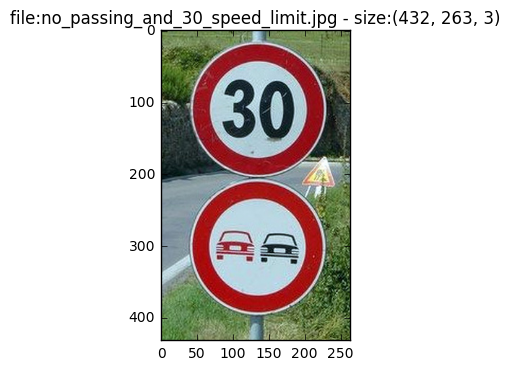

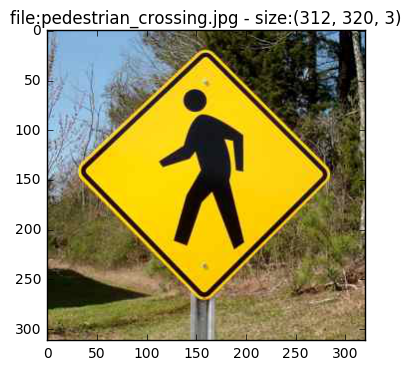

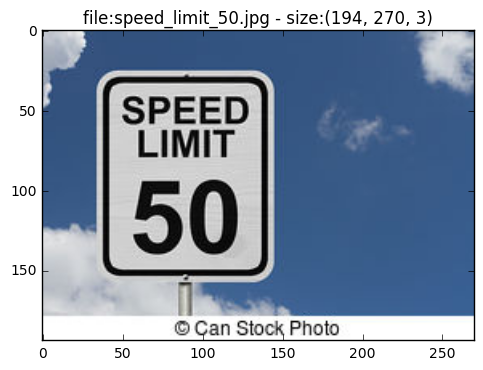

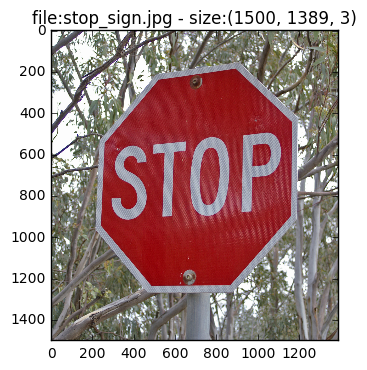

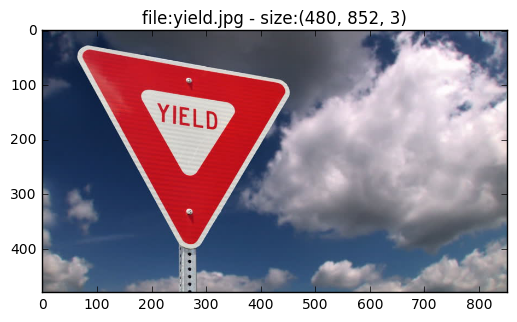

In [13]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

imgs = []
for filename in os.listdir('samplesigns'):
    plt.figure()
    img = plt.imread('samplesigns/' + filename)
    plt.title('file:{} - size:{}'.format(filename, img.shape))
    plt.imshow(img)
    imgs.append(img)
plt.show()



5


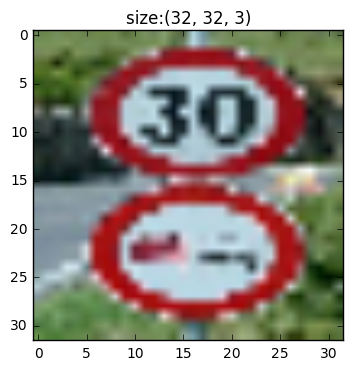

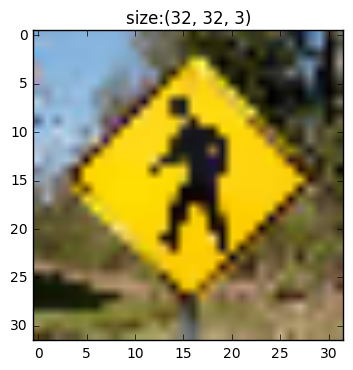

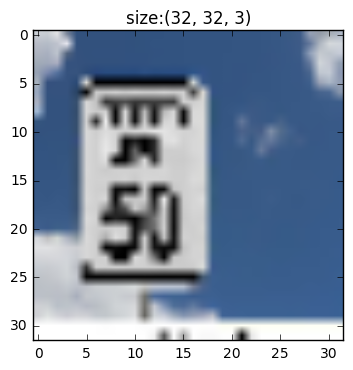

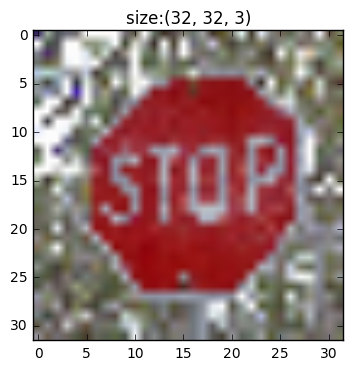

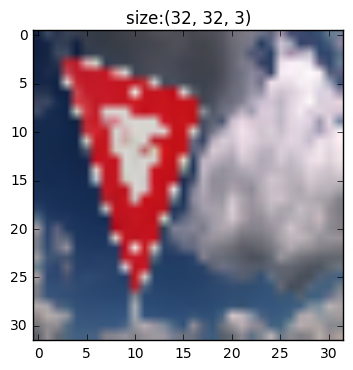

In [15]:
### We will resize the iimages to 32x32x3 and plot again


test_imgs = []
# with tf.Session() as sess:
for img in imgs:
    img_r = sess.run(tf.image.resize_images(tf.convert_to_tensor(img), (32, 32), method=1))
    test_imgs.append(img_r)

print(len(test_imgs))
    
for img in test_imgs:
    plt.figure()
    plt.title('size:{}'.format(img.shape))
    plt.imshow(img)
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
The original and resized images are plotted above. I used five images which are not from the test or train set. One of the images has two signs and it will be interesting to see how this gets classified.

In [16]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# Like the train set, I first resize the images from 0-255 -> 0-1

test_imgs = np.array(test_imgs).astype(np.float32)
test_imgs /= 255
test_prediction = sess.run(prediction, feed_dict={features: test_imgs, keep_prob:1.0})



In [17]:
print (test_prediction)

[42  5 35 14  5]


#### Let us look into the file `signnames.csv` to map the prediction class with labels.

**first sample**
- predicted - 42 - End of no passing by vechiles over 3.5 metric tons
- correct - 9 & 1 - No passing & Speed limit (30km/h)
- Got it **partially right** on no passing

**second sample **
- predicted - 5 - Speed limit (80km/h)
- correct - 27 - Pedestrians
- Got it **wrong**

**third Sample**
- predicted - 35 - Ahead only
- corect - 3 - Speed limit (50km/h)
- Got it **wrong**

**fourth sample**
- predicted - 14 - Stop
- correct - 14 - Stop
- Got it **right**

**fifth sample**
- predicted - 5 - Speed limit (80km/h)
- correct - 13 - yield
- Got it **wrong**

We see that only one out of 5 was predicted correctly. 


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**
The performance is not good at all in the new samples from web as compared to test set. I think the rescaling was also an issue. I realised this when I compared the rescaled images from my sample set with the 32x32 images in train data set.

The countries may have variations in the way same sign is shown. For a better check, I should have taken images from german roads to have a comparision of accuracy with german and other country traffic signs.

[[42 20 41 10 11]
 [ 5 14  7 10 29]
 [35  0 21  8 34]
 [14 17  5 15 13]
 [ 5 25 14 10 31]]
[[  9.82236710e+01   1.68652987e+00   4.65597175e-02   1.93307381e-02
    1.20674614e-02]
 [  9.99815979e+01   7.33124232e-03   5.10243140e-03   3.86057119e-03
    4.91185521e-04]
 [  7.39036026e+01   2.19096470e+01   2.33057022e+00   1.10381472e+00
    3.52934808e-01]
 [  1.00000000e+02   2.84266757e-20   2.51434050e-24   7.13672156e-25
    5.68211324e-29]
 [  9.99810638e+01   1.03699556e-02   6.51179999e-03   1.82017044e-03
    1.20308156e-04]]


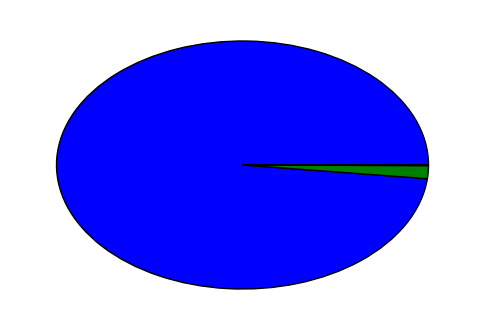

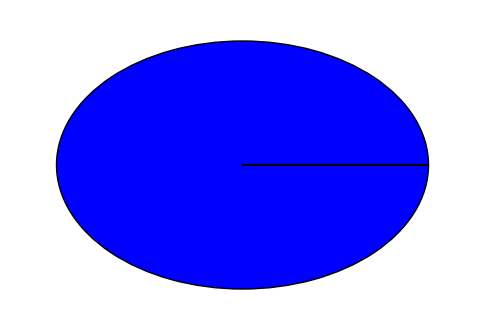

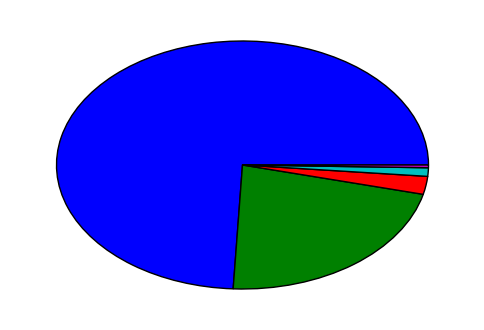

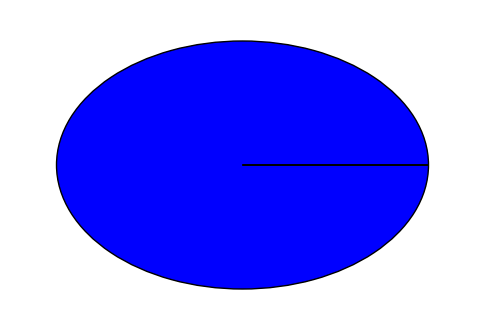

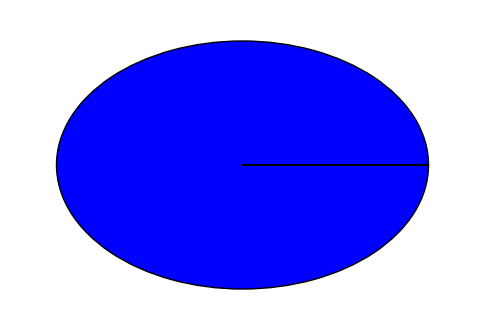

In [31]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
test_prediction = sess.run(tf.nn.top_k(probability, k=5), feed_dict={features: test_imgs, keep_prob:1.0})

print (test_prediction.indices)
print (test_prediction.values*100)


for val in test_prediction.values*100:
    plt.figure()
    plt.pie(val)
    plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
For all the wrong predictions, the correct prediction did not figure in the top 5 predictions. Also expect for the 3rd example, from above pie chart, we see that top prediction had a very high certainty.

This shows that the model developed above is not a very generalisable one. I plan to play around with some more models of NN to see how test accuracy can be increased for general images. Something for future exploration.



### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.